# Packages 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Functions 

## Read airbag data

In [2]:
def read_data(file_name):
    file_path = '../FallCatcher_Data/' + file_name
    data = pd.read_csv(file_path,sep=',',names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                  'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                  'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                  'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                  'fall_check','impact_value'])
    return data

## Read Manual Data

In [3]:
def read_combined_data(file_name,airbag_data):
    file_path = '../FallCatcher_Data/Combined/'+file_name
    data = pd.read_excel(file_path, sheet_name=0)
    data.to_csv(file_name, encoding='utf-8')
    data['Time Point Name'] = pd.to_numeric(data['Time Point Name'], errors='coerce')
    data = data[(data['Time Point Name']>100) & (data['Time Point Name'] < 200) &
                (data['Impact milisec'].notnull()) & ((data['Start milisec']) < (airbag_data.iloc[-1][0]))]
    data = data[['Time Point Name','Start milisec','Impact milisec', 'End Milisec','Duration']]
    return data

## Merge Airbag Data and manual Data  

In [4]:
def add_new_fall_value(airbag_data,manual_data):
    airbag_data['accel_base_mag'] =  np.sqrt(airbag_data['accel_base_X']**2 + airbag_data['accel_base_Y']**2 + 
                                             airbag_data['accel_base_Z']**2)
    for index, row in manual_data.iterrows():
        airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec']),
                                                 'cal_impact_milisec'] = 80

## Extract Feature

In [5]:
def extract_feature(data,window_time=1000,move_window = 0):
    if move_window != 0:
        move_window += int(window_time/2);
    max_ms = data['time_counter'].max()
    feature = pd.DataFrame(columns={'time_counter','min_acc','max_acc','fall_value'})
    impact_list = data.loc[(data['cal_impact_milisec'] == 80),'time_counter'].values
    
    end_list = []  #edge condition for non-fall values
    start_list = []
    non_falls_end_list = [0]
    
    #prepare window frame 
    for index in impact_list:
        end_list.append(index + int(window_time/2) - move_window)
        start_list.append(index - int(window_time/2) - move_window)
        non_falls_end_list.append(index + 2000)
    start_list.append(max_ms)  #edge condition for non-fall values
    
    #add fall values
    for index in range(len(impact_list)):
        start = start_list[index]
        end = end_list[index]
        
        temp_data = data.loc[(data['time_counter'] >= start) & (data['time_counter'] < end),['time_counter','accel_base_mag']]
        time_counter = temp_data.iloc[:,0].min()
        min_acc =  temp_data.iloc[:,1].min()
        max_acc = temp_data.iloc[:,1].max()
        fall_value = 1
        feature = feature.append({'time_counter':time_counter,'min_acc':min_acc,'max_acc':max_acc,'fall_value':fall_value},
                       ignore_index = True)
        
    #add non-fall values
    for start,end in zip(non_falls_end_list,start_list):
        for index in range(start,end,window_time):
            end_index = index + window_time
            if end_index < end:
                temp_data = data.loc[(data['time_counter'] >= index) & (data['time_counter'] < end_index),['time_counter','accel_base_mag']]
                time_counter = temp_data.iloc[:,0].min()
                min_acc =  temp_data.iloc[:,1].min()
                max_acc = temp_data.iloc[:,1].max()
                fall_value = 0
                feature = feature.append({'time_counter':time_counter,'min_acc':min_acc,'max_acc':max_acc,'fall_value':fall_value},
                                         ignore_index = True)

    return feature

## Nested Subject wise CV 

In [82]:
def outer_cross_val(X, Y, groups, split_model, model, params):

    print("Outer Cross Validation")
    Sensitivity = []
    Specificity = []

    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        predicted = best_inner_model.predict(X_test)
        
        cm1 = confusion_matrix(Y_test,predicted)
        sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        Sensitivity.append(sensitivity1)  

        specificity1 =  cm1[0,0]/(cm1[0,0]+cm1[0,1])
        Specificity.append(specificity1)
        #print('Specificity : ', specificity1)
        
    return sum(Sensitivity)/float(len(Sensitivity)), sum(Specificity)/float(len(Specificity))



## Inner CV

In [81]:
def inner_nested_cross_val(X, Y, cv, split_model, model, params):
    test_model = GridSearchCV(model, params, cv = cv ).fit(X, Y.values.ravel())
    return test_model.best_estimator_

## MIX ROC 

In [83]:
def roc_outer_cross_val(X, Y, groups, split_model, model, params,moving_window):
    
    title = 'ROC_AUC curve for MV = '+str(moving_window)
#     print("Outer Cross Validation")
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,7))
    plt.title(title)
    fold = 0
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.4,
                 label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))

        fold += 1
    
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8) 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.9)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    img_name = 'MV '+str(moving_window)+' ms.png'
    plt.savefig(img_name)
    plt.show()

## trail_roc_outer_cross_val

In [84]:
def trail_roc_outer_cross_val(X, Y, groups, split_model, model, params):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fold = 0
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = roc_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        fold += 1
    
    return tprs,mean_fpr,aucs

## Sensitivity with Specificity

In [80]:
def cal_sensitivity_with_specificity(X, Y, groups, split_model, model, params,specificity):
    
    print("trail Outer Cross Validation")
    tprs = []
    mean_fpr = np.linspace(0, 1, 1000)

    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr,fpr,tpr))
    mean_tpr = np.mean(tprs, axis=0)
    
    return np.interp(1-specificity,mean_fpr,mean_tpr)

## Read and Combine Airbag data and manual data

### For S1

In [10]:
s1_data=read_data('Airbag-S1.CSV')
s1_combined = read_combined_data('S1-combined.xlsx',s1_data)
add_new_fall_value(s1_data,s1_combined)

### For S2

In [11]:
s2_data=read_data('Airbag-S2.CSV')
s2_combined = read_combined_data('S2-combined.xlsx',s2_data)
add_new_fall_value(s2_data,s2_combined)

### For S3

In [12]:
s3_data=read_data('Airbag-S3.CSV')
s3_combined = read_combined_data('S3-combined.xlsx',s3_data)
add_new_fall_value(s3_data,s3_combined)

### For C1

In [13]:
c1_data=read_data('C1-Airbag.CSV')
c1_combined = read_combined_data('C1-combined.xlsx',c1_data)
add_new_fall_value(c1_data,c1_combined)

### For C2

In [14]:
c2_data=read_data('C2-Airbag.CSV')
c2_combined = read_combined_data('C2-combined.xlsx',c2_data)
add_new_fall_value(c2_data,c2_combined)

### For C3

In [15]:
c3_data=read_data('C3-Airbag.CSV')
c3_combined = read_combined_data('C3-combined.xlsx',c3_data)
add_new_fall_value(c3_data,c3_combined)

# Create features with moving window

In [87]:
window_size = 1000
last_window = 210
move_window = [10,20,50,100,150,200,250,300,350,400,2000]
# for index in range(window_size,last_window,window_size):
#     move_window.append(1000+index)


model = RandomForestClassifier(random_state=2)
n_estimators = list(range(50,120,10))
params = {'n_estimators':n_estimators}
groups = [1,2,3,4,5,6]
split_model = LeaveOneGroupOut()
data = [s1_data,s2_data,s3_data,c1_data,c2_data,c3_data]

table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
move_window
n_estimators

[50, 60, 70, 80, 90, 100, 110]

In [35]:
table.head(10)

,lead time(in ms),specificity,sensitivity
0,-1000.0,0.99,0.67
1,50.0,1.00,0.21
2,100.0,1.00,0.18
3,150.0,1.00,0.21


# test

## Sensitivity with specificity

In [99]:
specificity = 0.99
tpr_tnr_table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
move_window = [10,100,200,300,400,2000]

In [100]:
for index in move_window:
    X = []
    Y = []
    print("reading features on moved window frame by:{} ms".format(index))
    
    for inner_index in range(1,7):
        feature = pd.read_csv("./Features/"+str(index)+"_"+str(inner_index)+ ".csv")
        X.append(feature[['min_acc','max_acc']])
        Y.append(feature[['fall_value']])
        
    print("calculating sensitivity on moved window frame by:{} ms".format(index))
    
    sens = cal_sensitivity_with_specificity(X, Y, groups, split_model, model, params,specificity)
    tpr_tnr_table = tpr_tnr_table.append({'lead time(in ms)':index,'sensitivity':round(sens,3),'specificity':(specificity)},
                       ignore_index = True)

reading features on moved window frame by:10 ms
calculating sensitivity on moved window frame by:10 ms
trail Outer Cross Validation
reading features on moved window frame by:100 ms
calculating sensitivity on moved window frame by:100 ms
trail Outer Cross Validation
reading features on moved window frame by:200 ms
calculating sensitivity on moved window frame by:200 ms
trail Outer Cross Validation
reading features on moved window frame by:300 ms
calculating sensitivity on moved window frame by:300 ms
trail Outer Cross Validation
reading features on moved window frame by:400 ms
calculating sensitivity on moved window frame by:400 ms
trail Outer Cross Validation
reading features on moved window frame by:2000 ms
calculating sensitivity on moved window frame by:2000 ms
trail Outer Cross Validation


In [101]:
tpr_tnr_table.head(7)

,lead time(in ms),specificity,sensitivity
0,10.0,0.99,0.877
1,100.0,0.99,0.436
2,200.0,0.99,0.454
3,300.0,0.99,0.333
4,400.0,0.99,0.271
5,2000.0,0.99,0.027


## Feature Extraction and Saving

In [50]:
for index in move_window:
    print("extracting features on moved window frame by:{} ms".format(index))
    data_count = 1
    for temp_data in data:
        feature = extract_feature(temp_data,move_window=index)
        #saving features of each subject on a particular moving window
        feature.to_csv("./Features/"+str(index)+"_"+str(data_count)+ ".csv", sep=',',index=False)
        data_count += 1

extracting features on moved window frame by:10 ms
extracting features on moved window frame by:20 ms
extracting features on moved window frame by:50 ms
extracting features on moved window frame by:100 ms
extracting features on moved window frame by:150 ms
extracting features on moved window frame by:200 ms
extracting features on moved window frame by:250 ms
extracting features on moved window frame by:300 ms
extracting features on moved window frame by:350 ms
extracting features on moved window frame by:400 ms
extracting features on moved window frame by:2000 ms


## ROC graph on moving window

predicting on features by moved window frame by:10 ms
predicting on features by moved window frame by:100 ms
predicting on features by moved window frame by:200 ms
predicting on features by moved window frame by:300 ms
predicting on features by moved window frame by:400 ms
predicting on features by moved window frame by:2000 ms


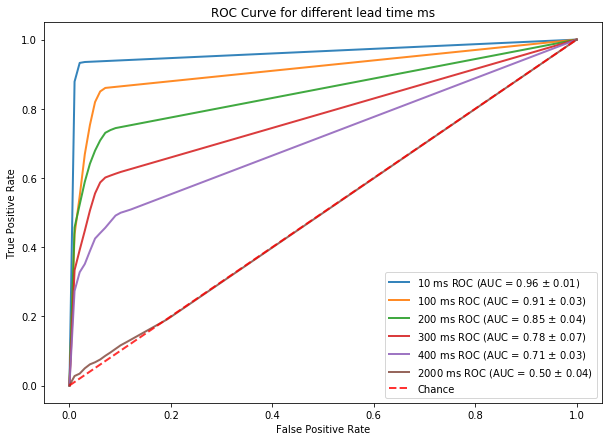

In [93]:
move_window = [10,100,200,300,400,2000]
plt.figure(figsize=(10,7))
for index in move_window:
    X = []
    Y = []
    print("predicting on features by moved window frame by:{} ms".format(index))
    
    for inner_index in range(1,7):
        feature = pd.read_csv("./Features/"+str(index)+"_"+str(inner_index)+ ".csv")
        X.append(feature[['min_acc','max_acc']])
        Y.append(feature[['fall_value']])
    tprs,mean_fpr,aucs = trail_roc_outer_cross_val(X, Y, groups, split_model, model, params)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=str(index)+' ms ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.9)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Chance', alpha=.8) 
plt.title('ROC Curve for different lead time ms')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
img_name = 'ROC_curve'+' ms.png'
plt.savefig(img_name)
plt.show()